In [9]:
import gym
import gym.wrappers
import numpy as np
import logging
import joblib
import threading
import matplotlib.pylab as pl
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

In [10]:
max_steps = 10000
gym.logger.setLevel(logging.ERROR)
env = gym.make("MountainCar-v0")
if isinstance(env, gym.wrappers.TimeLimit):
    env._max_episode_steps = max_steps
#env = gym.wrappers.Monitor(env, "mountaincar-res")

n_actions = env.action_space.n

print("n_actions=%i" % (n_actions))

n_actions=3


In [11]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(40,40),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));

/home/shmuma/anaconda3/envs/pract_rl/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [17]:
def generate_session(t_max=max_steps+1):
    loc_data = threading.local()
    if not hasattr(loc_data, "env"):
        loc_data.env = gym.make("MountainCar-v0")
        if isinstance(loc_data.env, gym.wrappers.TimeLimit):
            loc_data.env._max_episode_steps = t_max-1
        
    env = loc_data.env
    
    states, actions = [], []
    total_reward = 0
    s = env.reset()
    
    for _ in range(t_max):
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions, p=probs)
        new_s, r, done, _ = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
            
    return states, actions, total_reward

In [18]:
n_jobs = 4
n_samples = 250
percentile = 40
rewards = []
thresholds = []
finetune_mode = False

In [71]:
for i in range(100):
    #%time 
    sessions = joblib.Parallel(n_jobs)(joblib.delayed(generate_session)() for _ in range(n_samples))
    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))
    
    threshold = np.percentile(batch_rewards, percentile)
    elite_states = batch_states[batch_rewards > threshold]
    elite_actions = batch_actions[batch_rewards > threshold]
    
    if not elite_states.size:
        print("%d: no elite sessions, try again" % i)
        continue
    
    elite_states, elite_actions = map(np.concatenate, [elite_states, elite_actions])

    agent.partial_fit(elite_states, elite_actions, np.arange(n_actions))
    mean_reward = np.mean(batch_rewards)
    print("%d: mean reward = %.5f (max: %f)\tthreshold = %.1f" % (
        i, mean_reward, np.max(batch_rewards), threshold))
    thresholds.append(threshold)
    rewards.append(mean_reward)
    
    if mean_reward > -150:
        finetune_mode = True
        percentile = 75
        n_samples = 500
        print("Finetune mode!")

0: mean reward = -132.97600 (max: -107.000000)	threshold = -116.0
1: mean reward = -131.26800 (max: -107.000000)	threshold = -112.0
2: mean reward = -134.09000 (max: -107.000000)	threshold = -132.0
3: mean reward = -133.19400 (max: -107.000000)	threshold = -132.8
4: mean reward = -133.78800 (max: -107.000000)	threshold = -133.0
5: mean reward = -132.66200 (max: -107.000000)	threshold = -133.0
6: mean reward = -134.06200 (max: -107.000000)	threshold = -133.0
7: mean reward = -133.60200 (max: -107.000000)	threshold = -133.0
8: mean reward = -134.12000 (max: -107.000000)	threshold = -133.0
9: mean reward = -132.68800 (max: -107.000000)	threshold = -120.8
10: mean reward = -133.02800 (max: -107.000000)	threshold = -132.0
11: mean reward = -133.24600 (max: -107.000000)	threshold = -133.0
12: mean reward = -132.40400 (max: -107.000000)	threshold = -113.0
13: mean reward = -131.59600 (max: -107.000000)	threshold = -110.0
14: mean reward = -132.53200 (max: -107.000000)	threshold = -110.0
15: m

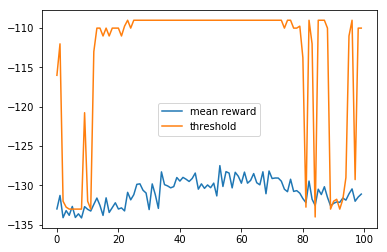

In [72]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()

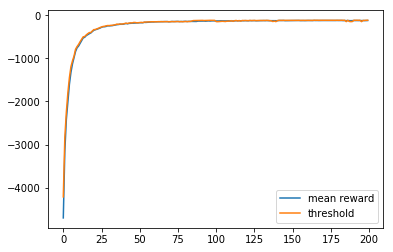

In [60]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()

In [61]:
env.close()